In [11]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.signal import fftconvolve
from skimage.transform import resize
import xdesign as xd

cp.cuda.Device(0).use()

<CUDA Device 0>

In [24]:
def set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, np.pi, N_angle, endpoint=False)

    n = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    pitch = 1.
    t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
    t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
    t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

    n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
    t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
    t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
    extra   = np.ones((1,N_angle*N_offset,1))
    origin  = (0., 0.)
    pitch   = (1.,1.)

    t_spec  = cp.array(t_spec)
    n_spec  = cp.array(n_spec)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels, op_splines_1, op_splines_2

def create_phantom(N_side, type):
    if type=='gaussian':
        xx = np.linspace(-N_side//2,N_side//2, num=N_side)
        yy = xx
        X, Y = np.meshgrid(xx,yy)
        r = 700
        mask = np.sqrt(X**2 + Y**2) < r
        phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)

    if type=='sharp':
        seed = 0
        # Generate phantom with xdesign
        np.random.seed(seed)
        p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
        phantom = xd.discrete_phantom(p1, N_side-400-370) * 10
        phantom = np.pad(phantom, ((370, 0), (370, 0)))
        phantom = np.abs(np.pad(phantom, 200))
    return cp.array(phantom)

/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/xdesign/phantom/phantom.py:375: RuntimeWarning: Reached termination criteria of 500 attempts before adding all of the circles.
  warnings.warn((


(3000, 3000)


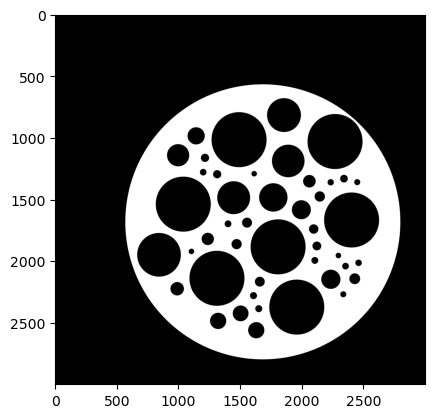

In [13]:
#interactive matplotlib backend

N_side = 3000 #5000

phantom = create_phantom(N_side, "sharp")

# load phantom
#phantom = cp.array(np.load('phantom.npy'))

arg_shape = phantom.shape
print(arg_shape)
plt.figure()
plt.imshow(phantom.get(), cmap='gray')
plt.show()


INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.137779] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.157488] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.168829] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.180193] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.191482] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.202640] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.213811] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.224890] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.235976] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.247282] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_o_u2ha1t:[2025-02-18 14:27:07.258370] Iteration 10
	iteration: 1

sample normal
norm diff splines :  2344.3106442526287
norm diff pixels  :  423.24051717925124
Oversampled
norm diff splines :  111957.47724066484
norm diff pixels  :  135754.23106628677
14334.909643026476
14290.785324426324


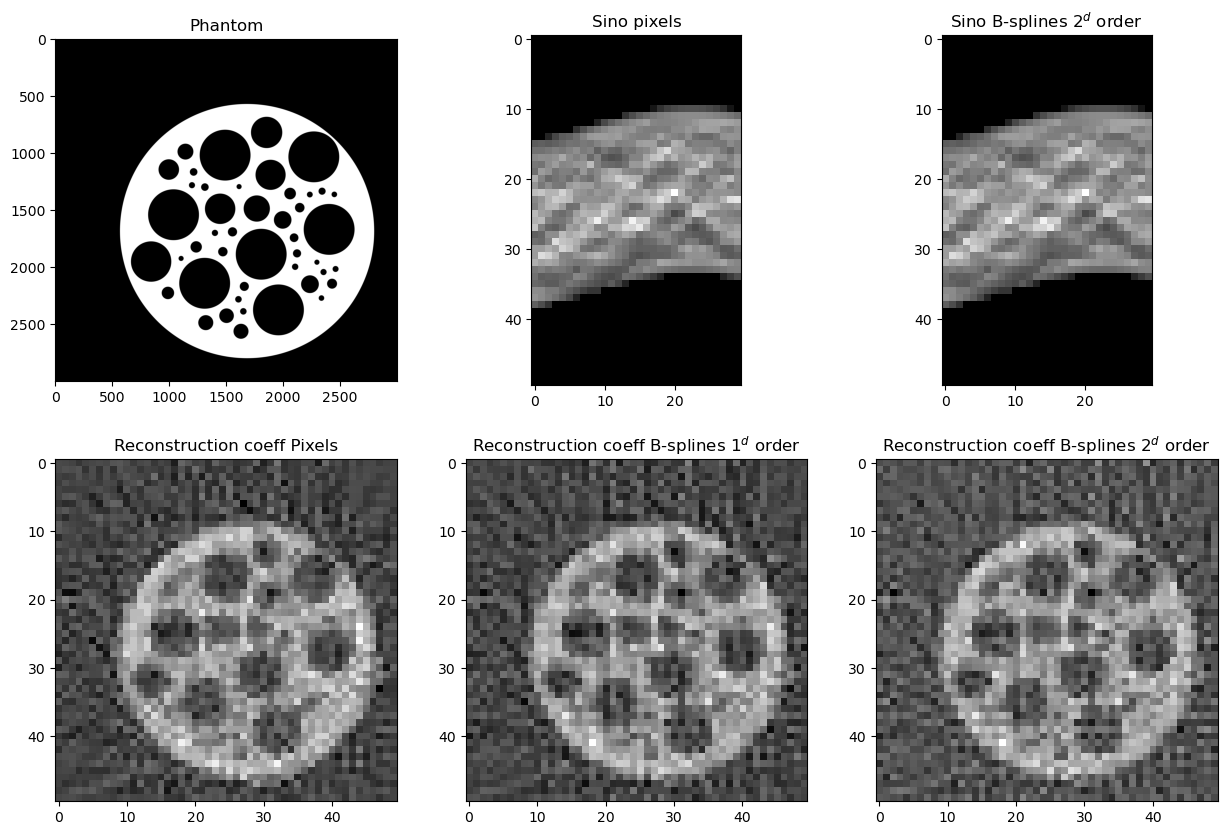

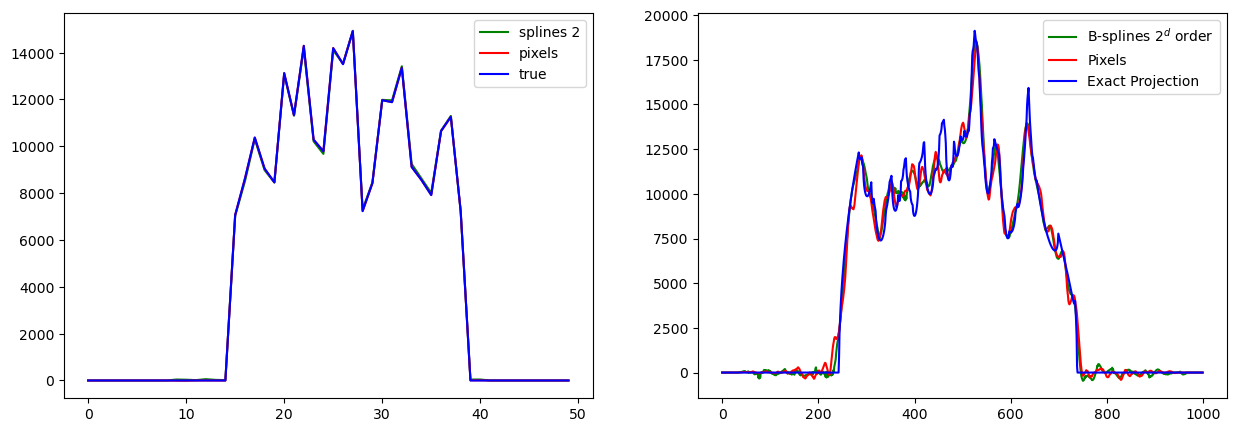

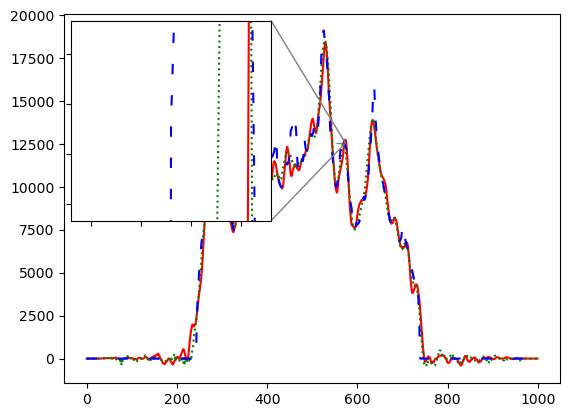

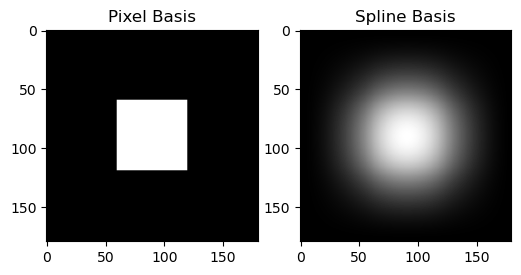

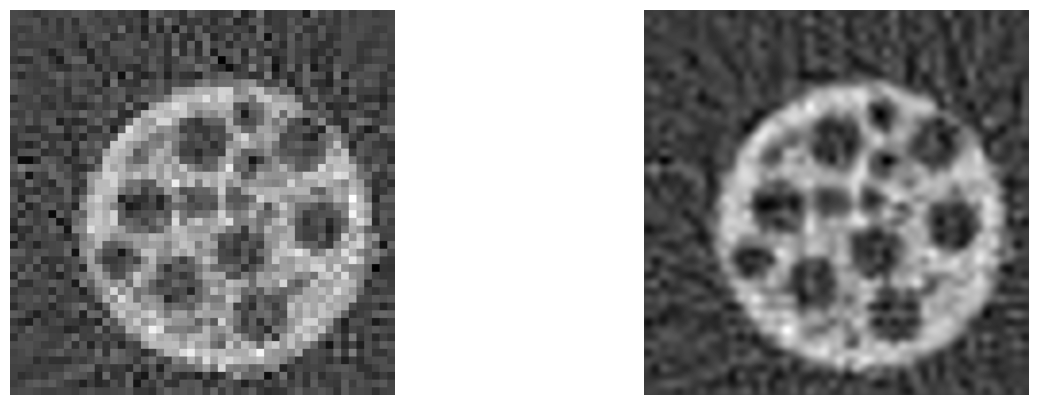

In [14]:

pitch_op = (1.,1.) 
N_angle  = 30
N_offset = 50
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

N_offset_true = 1000
op_true, _, _ = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() 
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get()
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() 
sinogram_astra = fwd_pixels

stop_crit = pxst.MaxIter(30)

oversampling = 50
pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
arg_shape = (oversampling, oversampling)
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_pixels.T, cmap='gray')
axes[0, 1].set_title('Sino pixels')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()

N_offset = 1000
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

#dotted lines
ax.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')
axins.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')

#dashed lines
ax.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))
axins.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))

x_baseline = 563
y_true = true_proj[9][x_baseline]
x1, x2, y1, y2 = x_baseline-10, x_baseline+10, y_true-10, y_true+10
#505+10, 505+20, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()
plt.savefig('inset.eps', format='eps')

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

NN = phantom.shape[0]//oversampling
mini_im = np.zeros((3*NN, 3*NN))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[NN:2*NN, NN:2*NN] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')
mini_im_spline = spconv(mini_im_spline, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')

ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(full_im_pix[NN:-NN, NN:-NN], cmap='gray')
ax[1].imshow(full_im_spline[NN:-NN, NN:-NN], cmap='gray')
for a in ax:
    a.axis('off')
plt.savefig('upsampled.eps', format='eps')

print(np.linalg.norm(full_im_pix[NN:-NN, NN:-NN]/np.max(full_im_pix[NN:-NN, NN:-NN]) - phantom.get()))
print(np.linalg.norm(full_im_spline[NN:-NN, NN:-NN]/np.max(full_im_spline[NN:-NN, NN:-NN]) - phantom.get()))

plt.show()

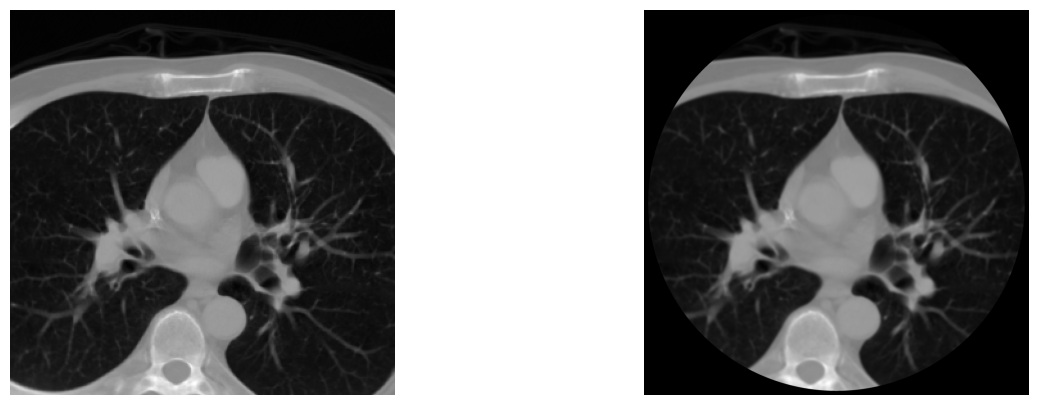

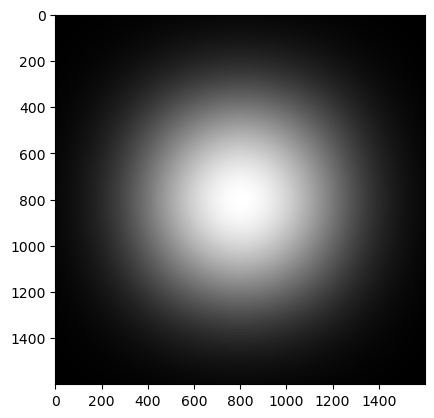

In [25]:
import astra 

N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')
final_size = N_side
#spline_basis_1 = np.flip(spline_basis_1, axis=0)

#random_phantom = np.random.randn(50, 50)
from skimage import io

image_path = "true.tiff"
# Open the TIFF image
'''random_phantom = io.imread(image_path)[100:475, 60:435]
oversampling = 375'''
random_phantom = io.imread(image_path)[100:400, 100:400]
oversampling = 300
factor = final_size//oversampling

spline_basis_3 = fftconvolve(spline_basis_0, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')

spline_basis = resize(spline_basis_3, (3*factor, 3*factor), anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = random_phantom[i, j]

phantom = fftconvolve(full_im_spline, spline_basis, mode='same')
#circle mask with zeros outside
XX, YY = np.meshgrid(np.linspace(-1, 1, final_size), np.linspace(-1, 1, final_size))
mask = np.sqrt(XX**2 + YY**2) < 0.9787
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom *mask
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(random_phantom, cmap='gray')
ax[1].imshow(phantom, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()

phantom = cp.array(phantom)/np.max(phantom)
plt.figure()
plt.imshow(spline_basis_3, cmap='gray')
plt.show()

#phantom = create_phantom(N_side, "gaussian")
phantom /= cp.max(phantom)

def run_xp(N_angle, N_offset, oversampling, phantom):
    
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    angles = np.linspace(0, np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = N_side/N_offset
    proj_geom = astra.create_proj_geom('parallel', det_spacing, N_offset, angles)
    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    sinogram_id, y_data = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data).reshape(-1) #+ 0.2*cp.random.randn(N_angle*N_offset)
    
    stop_crit = pxst.MaxIter(20)
    
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    factor = final_size//oversampling
    rec_pix = recon_pixels.get()
    spline_basis = resize(spline_basis_0, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_pix = np.zeros((final_size, final_size))

    for i in range(oversampling):
        for j in range(oversampling):
            full_im_pix[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_pix[i, j]


    full_im_pix = fftconvolve(full_im_pix, spline_basis, mode='same')

    rec_spline = recon_box_1.get()
    spline_basis = resize(spline_basis_1, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline1 = fftconvolve(full_im_spline, spline_basis, mode='same')

    rec_spline = recon_box_2.get()
    spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline2 = fftconvolve(full_im_spline, spline_basis, mode='same')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(full_im_pix, cmap='gray')
    ax[1].imshow(full_im_spline1, cmap='gray')
    ax[2].imshow(full_im_spline2, cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1))
    loss3 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2))
    
    plt.show()

    return loss1, loss2, loss3


Oversampling :  20


INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.041494] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.061712] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.073581] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.085269] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.096626] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.108057] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.119468] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.131119] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.142519] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.153934] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_py5ge5gv:[2025-02-18 14:35:39.165496] Iteration 10
	iteration: 1

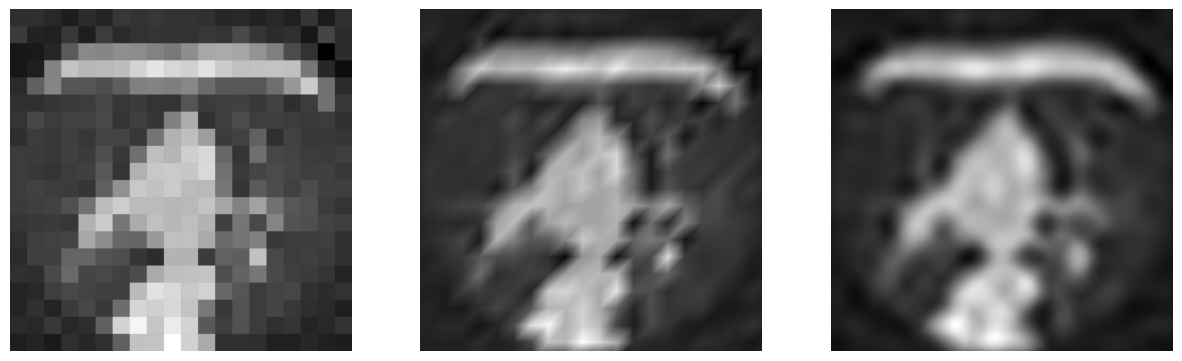

Losses :  17.225163554383087 20.638065187421443 19.551804997030153
Oversampling :  40


INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.240041] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.260968] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.272719] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.284524] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.296260] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.307981] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.319333] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.330797] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.341973] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.353145] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_l02uufst:[2025-02-18 14:35:45.364757] Iteration 10
	iteration: 1

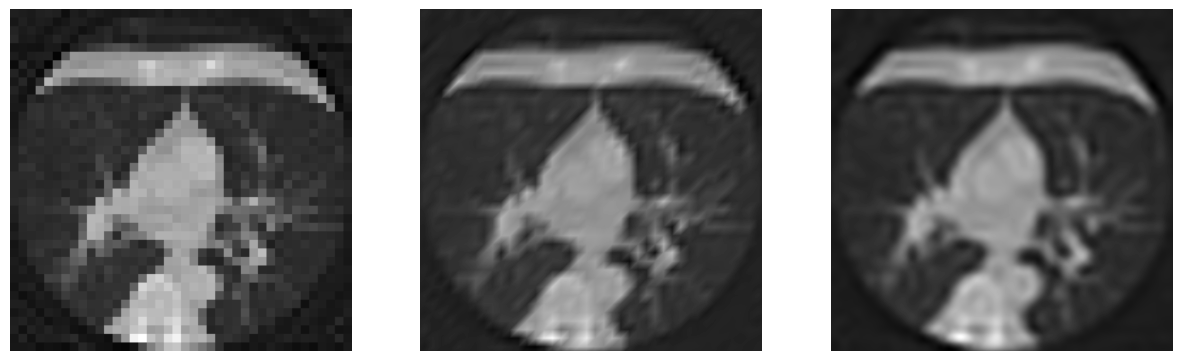

Losses :  21.916168913226226 24.389843715022018 25.027613189327194
Oversampling :  50


INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.554362] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.576484] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.588411] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.600271] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.612046] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.623766] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.635311] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.646704] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.657985] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.669330] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_9p75pt4v:[2025-02-18 14:35:51.680688] Iteration 10
	iteration: 1

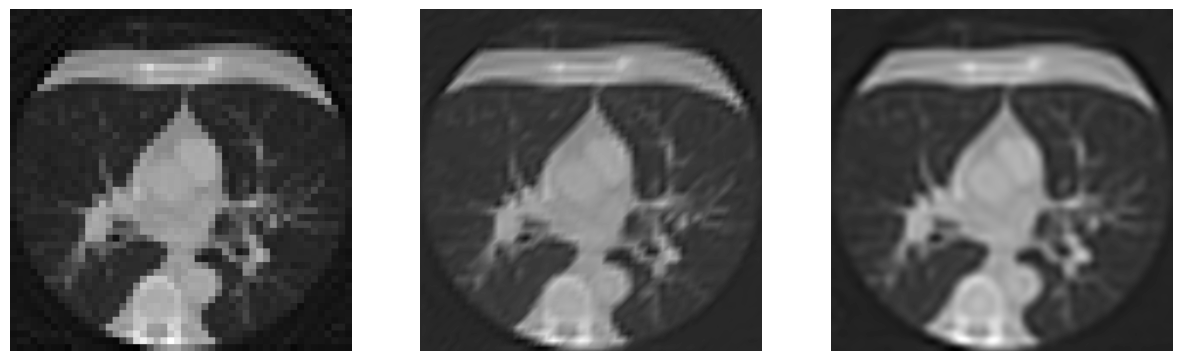

Losses :  23.680751262776077 25.601118389572935 26.043954515063525
Oversampling :  75


INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.292916] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.315156] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.326877] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.338386] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.350117] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.361516] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.372632] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.383652] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.394698] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.405752] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_k2jx6ib9:[2025-02-18 14:35:58.417243] Iteration 10
	iteration: 1

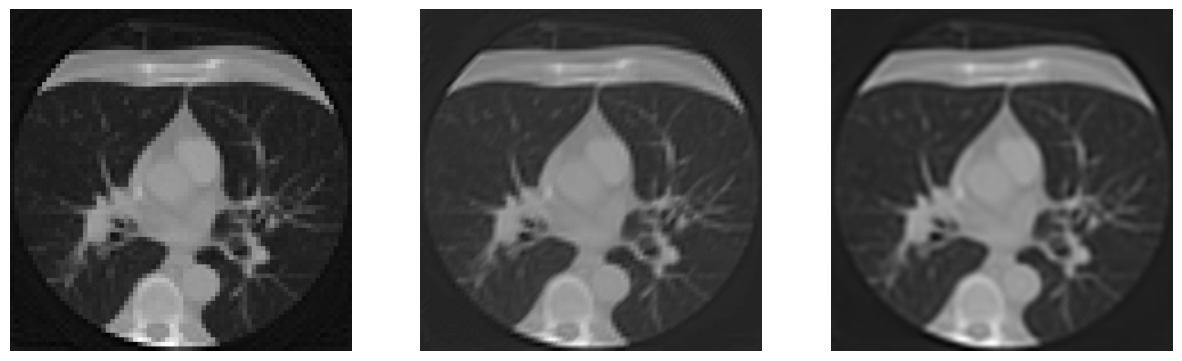

Losses :  26.12808395511977 25.349776699628027 27.630140611125768
Oversampling :  100


INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:05.914839] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:05.935789] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:05.947254] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:05.958541] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:05.970344] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:05.982164] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:05.993056] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:06.004247] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:06.015719] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:06.026992] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_n9umcytj:[2025-02-18 14:36:06.038422] Iteration 10
	iteration: 1

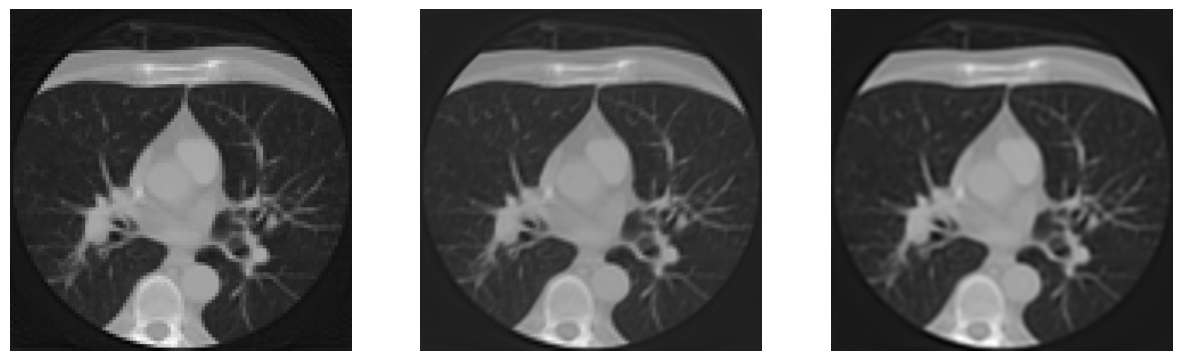

Losses :  27.809749182758708 29.47325529962245 30.706309544691905
Oversampling :  120


INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.191873] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.212988] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.224420] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.236097] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.247729] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.259381] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.270993] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.282558] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.294013] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.305614] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_6hx7f6_c:[2025-02-18 14:36:14.317111] Iteration 10
	iteration: 1

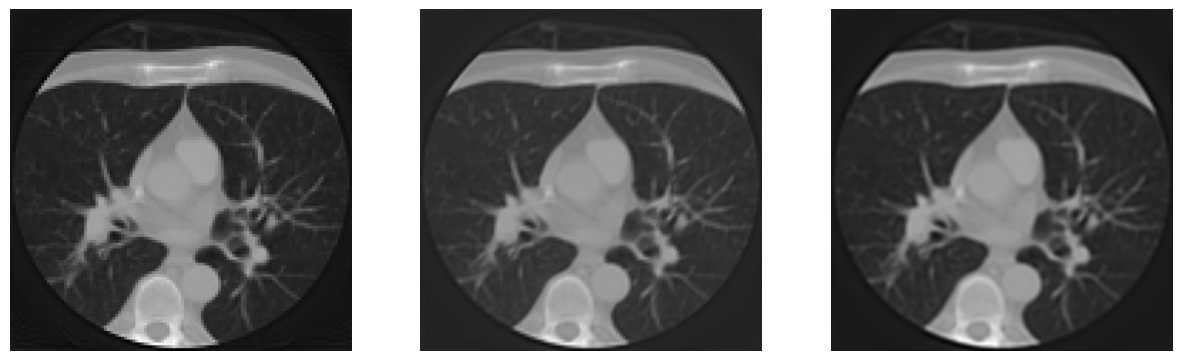

Losses :  28.913233213615058 28.835984809520326 31.324282294100723
Oversampling :  150


INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.884783] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.904790] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.916271] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.927597] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.939383] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.950309] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.961513] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.972577] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.983600] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:23.994715] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_yej5gxl_:[2025-02-18 14:36:24.005756] Iteration 10
	iteration: 1

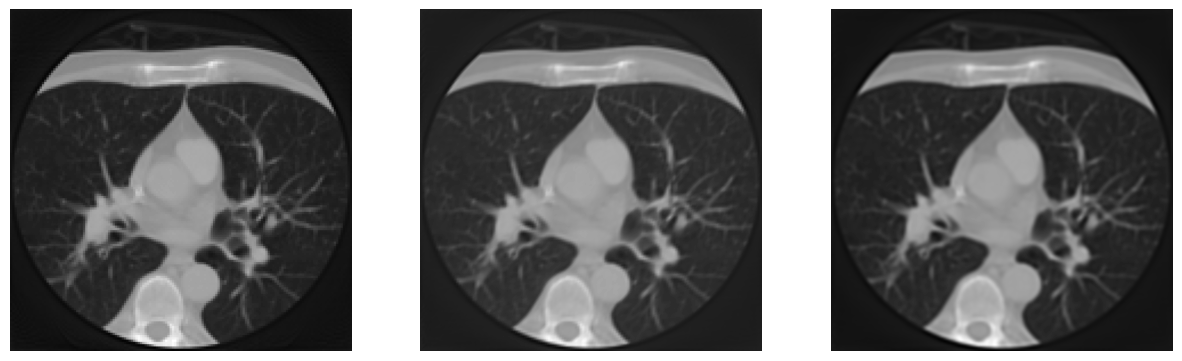

Losses :  29.982949185737464 33.146644282901995 33.034679777602875
Oversampling :  200


INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.153487] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.173049] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.184446] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.196107] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.207992] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.219899] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.231719] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.243541] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.255731] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.267435] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_4_0gmc_i:[2025-02-18 14:36:36.279013] Iteration 10
	iteration: 1

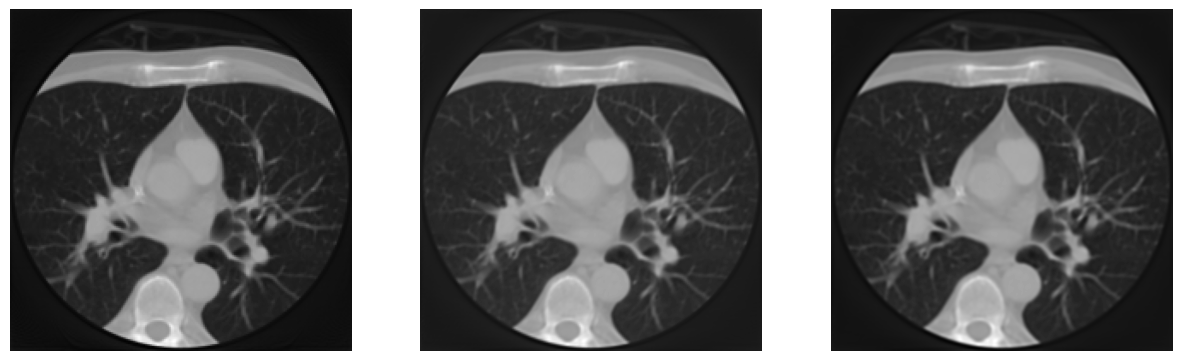

Losses :  32.007015996374186 34.64764962391637 34.08452015105601
Oversampling :  250


INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.605334] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.626063] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.638442] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.650859] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.663376] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.675784] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.688412] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.701176] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.713848] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.726423] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_oezkpf3q:[2025-02-18 14:36:51.739041] Iteration 10
	iteration: 1

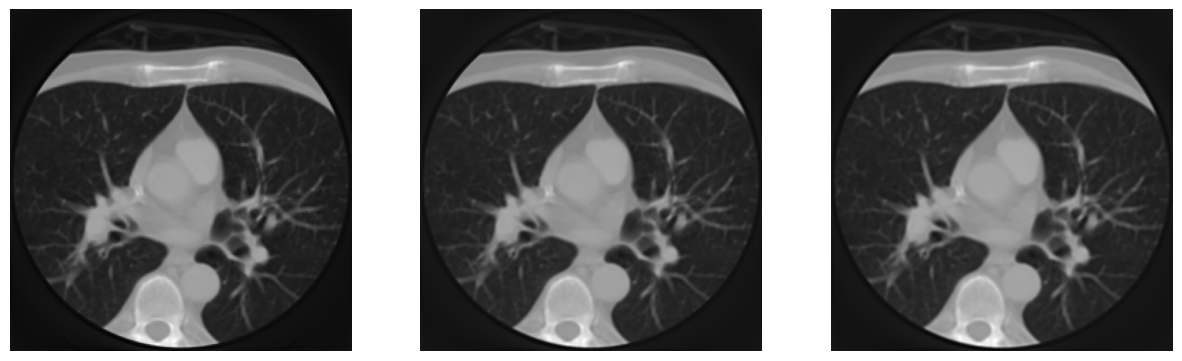

Losses :  33.47673179375151 35.98179019933396 35.439012882719965
Oversampling :  300


INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.652045] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.674776] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.688615] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.702217] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.715823] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.729708] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.743589] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.757732] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.771926] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.786248] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_mknae21y:[2025-02-18 14:37:10.800638] Iteration 10
	iteration: 1

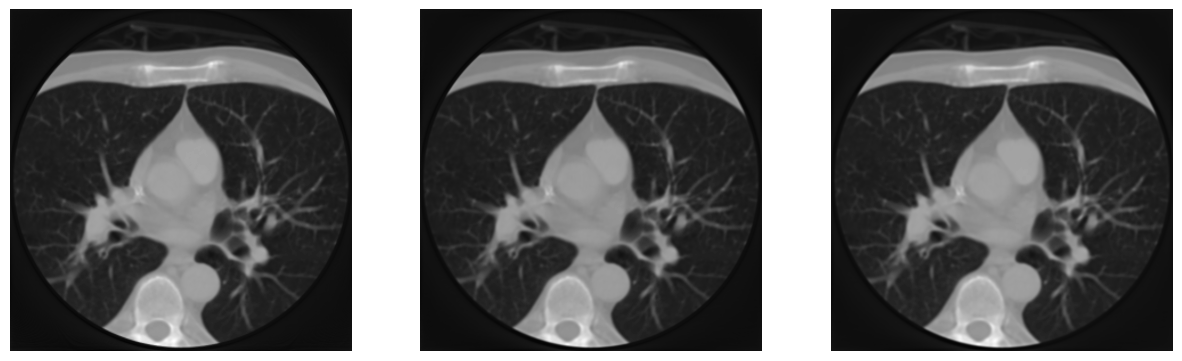

Losses :  34.69101921456041 35.70176001335821 36.6639923274846
Oversampling :  375


INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.681523] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.704635] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.720299] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.736156] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.752054] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.767970] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.783792] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.800111] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.815827] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.831734] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_verjarlc:[2025-02-18 14:37:35.847295] Iteration 10
	iteration: 1

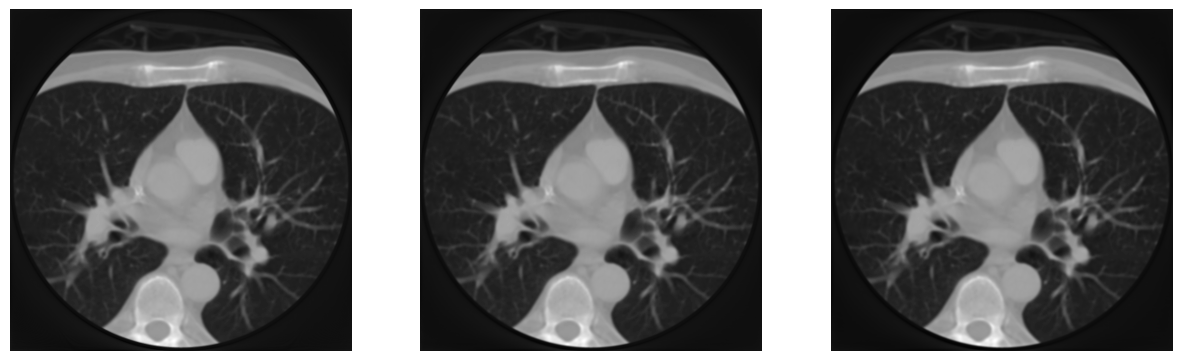

Losses :  35.49780535664255 37.15983697624117 36.90756172178199
Oversampling :  500


INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:12.930087] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:12.964575] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:12.987791] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.011692] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.035547] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.059071] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.082970] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.106832] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.130357] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.153476] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_7piqpcig:[2025-02-18 14:38:13.175449] Iteration 10
	iteration: 1

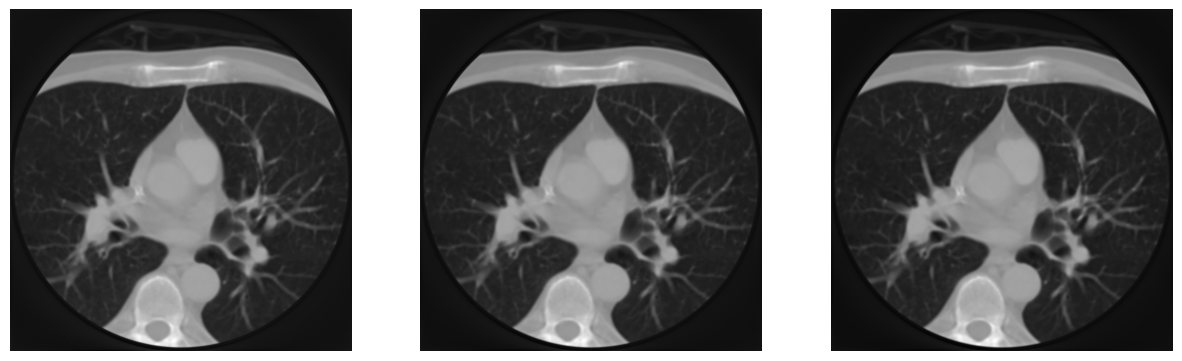

Losses :  36.76002766210616 38.11670829575859 37.88933490803163


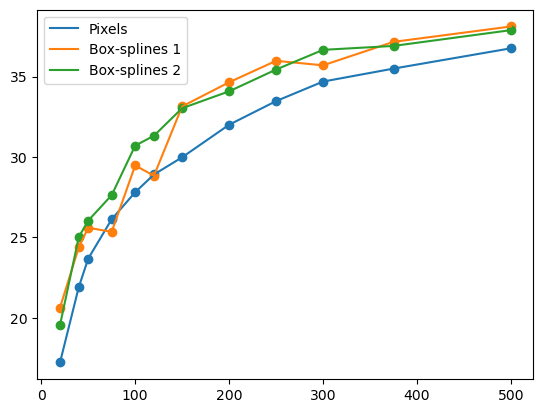

In [26]:
oversamplings =[20, 40, 50, 75, 100, 120, 150, 200, 250, 300, 375, 500]#, 1000, 1250, 2500, 5000]

losses1 = []
losses2 = []
losses3 = []
for oversampling in oversamplings:
    print('Oversampling : ', oversampling)
    loss1, loss2, loss3 = run_xp(2*oversampling, 2*oversampling, oversampling, phantom) #900, 900
    losses1.append(loss1)
    losses2.append(loss2)
    losses3.append(loss3)
    print('Losses : ', loss1, loss2, loss3)

plt.figure('Losses')
plt.plot(oversamplings, losses1, label='Pixels')
plt.plot(oversamplings, losses2, label='Box-splines 1')
plt.plot(oversamplings, losses3, label='Box-splines 2')
plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.scatter(oversamplings, losses3)
plt.legend()
plt.show()